In [1]:
#因子的ic分析
#获得2018-06-06的因子暴露度
#获得2018-06-07的股票收益
#计算相关系数

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
from alphalens import performance
from alphalens import plotting
from alphalens import tears
from alphalens import utils

In [3]:
q = query(fundamentals.income_statement.basic_earnings_per_share)
fund = get_fundamentals(q,entry_date="2018-06-06").major_xs("2018-06-06 00:00:00")

/usr/local/lib/python3.6/site-packages/rqdatac/services/financial.py:339: UserWarning: Panel is  removed after pandas version 0.25.0.the  default value of 'expect_df' will change to True in the future.
  warnings.warn("Panel is  removed after pandas version 0.25.0."


In [4]:
fund["basic_earnings_per_share"] = fund["basic_earnings_per_share"].fillna(fund["basic_earnings_per_share"].mean())

In [5]:
price_now = get_price(list(fund.index),start_date="2018-06-06",end_date="2018-06-06",fields=['close']).T

In [6]:
price_next = get_price(list(fund.index),start_date="2018-06-07",end_date="2018-06-07",fields=['close']).T

In [7]:
#计算收益率
stock_list = (price_next.iloc[:,0]-price_now.iloc[:,0])/price_now.iloc[:,0]

In [8]:
#相关性计算
st.spearmanr(fund["basic_earnings_per_share"].tolist(),stock_list.tolist())

SpearmanrResult(correlation=0.00710072611628505, pvalue=0.6735662979904744)

# 使用alphalens计算ic
#先准备数据

In [9]:
date = get_trading_dates(start_date='2017-01-01',end_date='2017-01-31')

In [10]:
all_data = pd.DataFrame()

In [11]:
for i in range(len(date)):
    #获取每股收益的ic因子
    q = query(fundamentals.financial_indicator.return_on_equity)
    
    factor = get_fundamentals(q,entry_date=date[i]).iloc[:,0,:]
    
    #新建日期列，为了指定这些事date[i]日期因子数据，以便于设置索引
    factor['date'] = date[i]
    
    #print(factor)
    
    #每次循环一次，就拼接起来
    all_data = pd.concat([all_data,factor])

/usr/local/lib/python3.6/site-packages/rqdatac/services/financial.py:339: UserWarning: Panel is  removed after pandas version 0.25.0.the  default value of 'expect_df' will change to True in the future.
  warnings.warn("Panel is  removed after pandas version 0.25.0."


In [12]:
#自己实现标准化
def stand(factor):
    mean = factor.mean()
    std = factor.std()
    
    return (factor - mean)/std

#3、去极值的方法
def mad(factor):
    #1、
    me = np.median(factor)
    
    #2、3、
    mad = np.median(abs(factor - me))
    
    up = me + (3 * 1.4826 * mad)
    down = me - (3 * 1.4826 * mad)
    
    #利用3倍中位数的值去极值
    factor = np.where(factor > up,up,factor)
    factor = np.where(factor < down,down,factor)
    
    return factor


In [13]:
#设置双重索引，变成一个MutiIndex DataFrame,date加原来的索引
multiindex_df= all_data.set_index(['date',all_data.index])

In [14]:
#处理因子数据，去极值，标准化
multiindex_df['return_on_equity'] = mad(multiindex_df['return_on_equity'])
multiindex_df['return_on_equity'] = stand(multiindex_df['return_on_equity'])

In [15]:
#MutlINdex ----> MultiINdex Series
singlefactor_multiindex_series = multiindex_df['return_on_equity']

In [16]:
singlefactor_multiindex_series.shape

(55126,)

In [17]:
#2、准备收盘价数据，股票的所有A股
stock = all_instruments('CS')
stock_list = stock['order_book_id']
price = get_price(list(stock_list),start_date='2017-01-01',end_date='2018-01-01',fields=['close'])

In [18]:
#3alpahlens.utils.get_clean_factor_and_forward_returns生成通用的alpha数据结构
factor_return = utils.get_clean_factor_and_forward_returns(singlefactor_multiindex_series,price)

Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [19]:
factor_return

1D        5D       10D     factor  \
date       asset                                                  
2017-01-03 000010.XSHE  0.005135 -0.010270 -0.116816  -0.710458   
           000014.XSHE  0.012825  0.009501 -0.108315   -1.26993   
           000006.XSHE  0.013453  0.009318 -0.116851  -0.452046   
           000008.XSHE  0.005353  0.013920 -0.069591 -0.0751785   
           000012.XSHE  0.012282  0.033335 -0.015780   0.593687   
           000011.XSHE  0.012377  0.001548 -0.144920  -0.926475   
           000007.XSHE  0.014178 -0.050190 -0.087736  -0.132951   
           000009.XSHE  0.018166  0.015304 -0.082209  -0.121234   
           000001.XSHE  0.000000 -0.001092 -0.001092   0.792776   
           000002.XSHE  0.005789 -0.007236  0.003374   0.446026   
           000004.XSHE  0.005624 -0.026997 -0.159280    1.77297   
           000005.XSHE  0.026354  0.026354 -0.051245   0.888227   
           000016.XSHE  0.008772  0.019743 -0.039485   -1.12566   
           000017.XSHE  0.099922  0.071819 -0.098361    1.72642   
           000018.XSHE  0.000954 -0.035271 -0.083895    2.35485   
           000019.XSHE  0.014687  0.025093 -0.112606   -1.34884   
           000021.XSHE  0.011478  0.020878 -0.020878  0.0468099   
           000022.XSHE  0.006724 -0.005170 -0.085359   0.638975   
           000023.XSHE -0.000628 -0.029977 -0.121173  -0.527515   
           000020.XSHE  0.004005  0.004005 -0.109924  -0.642134   
           000025.XSHE  0.008792 -0.001975 -0.088462  -0.395392   
           000026.XSHE  0.100142  0.134249 -0.020319  -0.129642   
           000027.XSHE  0.005784  0.026011 -0.017336   0.120968   
           000028.XSHE  0.008753  0.025222  0.024480    0.85106   
           000029.XSHE  0.000000  0.000000  0.000000   0.675167   
           000030.XSHE  0.003467 -0.010401 -0.073913    0.84003   
           000031.XSHE  0.004437 -0.003316 -0.093123  -0.660054   
           000032.XSHE  0.018816  0.094762 -0.004030  -0.221337   
           000033.XSHE  0.000000  0.000000  0.000000    2.35485   
           000034.XSHE  0.017466 -0.027314 -0.093145    2.35485   
...                          ...       ...       ...        ...   
2017-01-26 300597.XSHE  0.099999  0.610373  1.594331   0.651348   
           300576.XSHE -0.000240  0.058849  0.051911    1.08906   
           300581.XSHE  0.035426  0.016952 -0.047031   0.638784   
           300592.XSHE  0.100086  0.610556  1.594177   0.603615   
           603337.XSHG -0.041335  0.037790  0.114852    1.99858   
           300568.XSHE -0.032049  0.026990 -0.048916    2.35485   
           600996.XSHG  0.001321  0.058751  0.114197    2.35485   
           603393.XSHG  0.001536  0.040544  0.111332   0.732477   
           603996.XSHG  0.003048  0.064977  0.045688  -0.148746   
           300593.XSHE  0.100137  0.610736  0.810100   0.914252   
           000166.XSHE -0.009515  0.012681  0.023763   0.349439   
           300577.XSHE  0.001716  0.057945  0.107706    2.35485   
           300583.XSHE  0.012869  0.041636  0.079636    1.37672   
           603058.XSHG  0.099832  0.102317  0.028998    1.07248   
           300585.XSHE -0.033704  0.070899  0.030451     1.9197   
           300590.XSHE -0.046397 -0.012985 -0.039091    2.35485   
           300588.XSHE  0.099903  0.357218  0.375044   0.827641   
           300602.XSHE  0.099812  0.610116  1.593228    1.65603   
           300595.XSHE  0.099987  0.610381  0.498279    2.35485   
           300584.XSHE  0.022886  0.080702  0.104072    1.13529   
           300599.XSHE  0.099998  0.611105  1.048139    1.00197   
           300591.XSHE  0.100142  0.610947  0.862382    0.81263   
           300603.XSHE  0.100742  0.610675  1.596926   0.218706   
           300498.XSHE -0.010417 -0.014361 -0.036599    2.35485   
           601155.XSHG -0.017098  0.028745  0.024084   0.265673   
           002827.XSHE -0.012008  0.046217  0.094255    2.35485   
           002826.XSHE  0.002133  0.066069  0.124041    1.26724   
          

In [20]:
#4计算因子并进行分析
ic = performance.factor_information_coefficient(factor_return)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce806d3f28>,
      dtype=object)

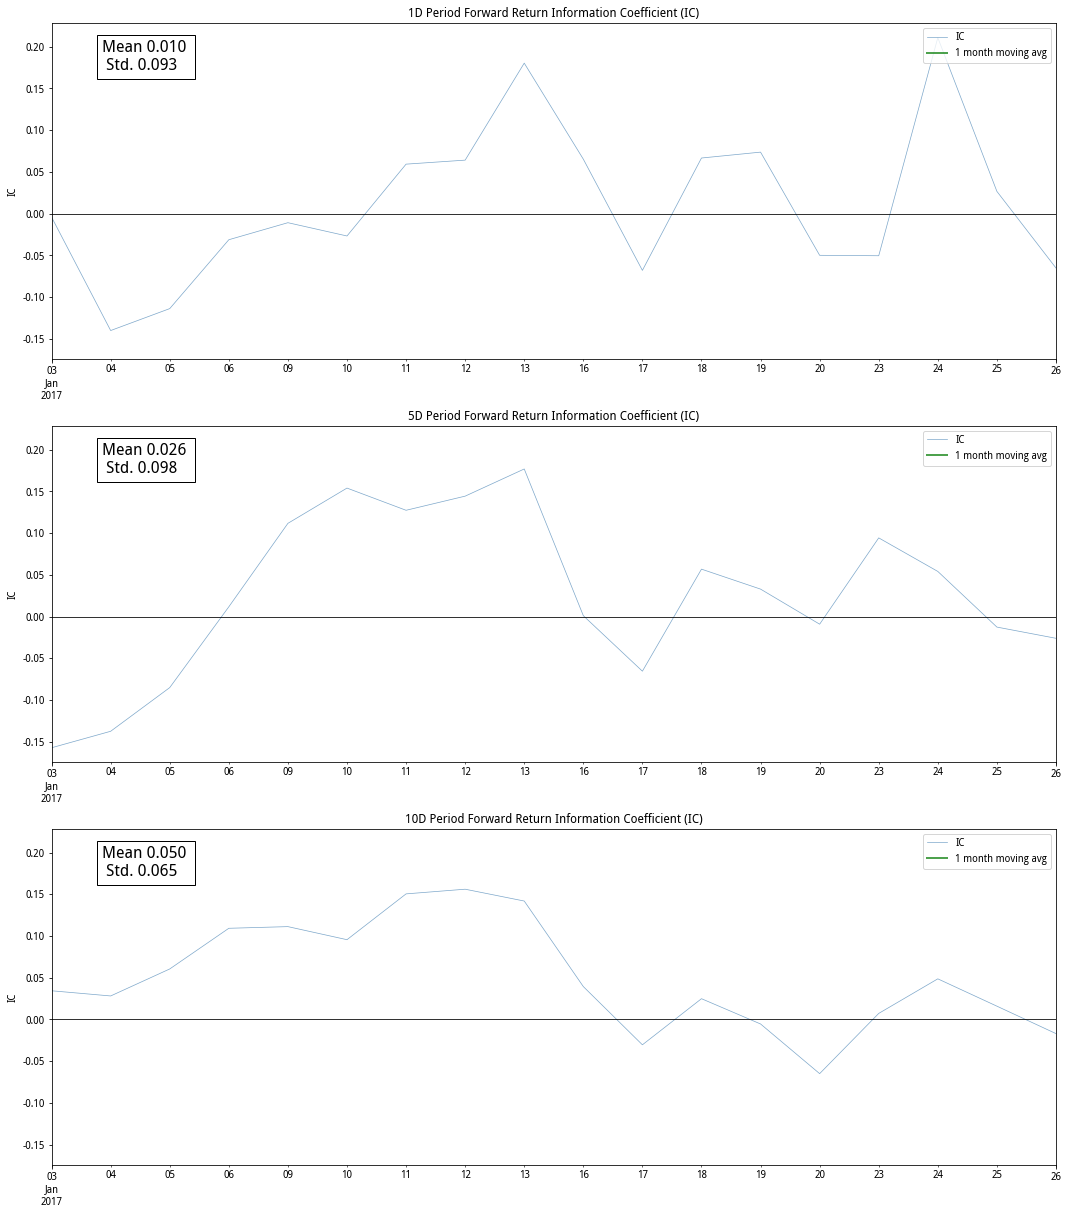

In [22]:
plotting.plot_ic_ts(ic)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce9d6176a0>,
      dtype=object)

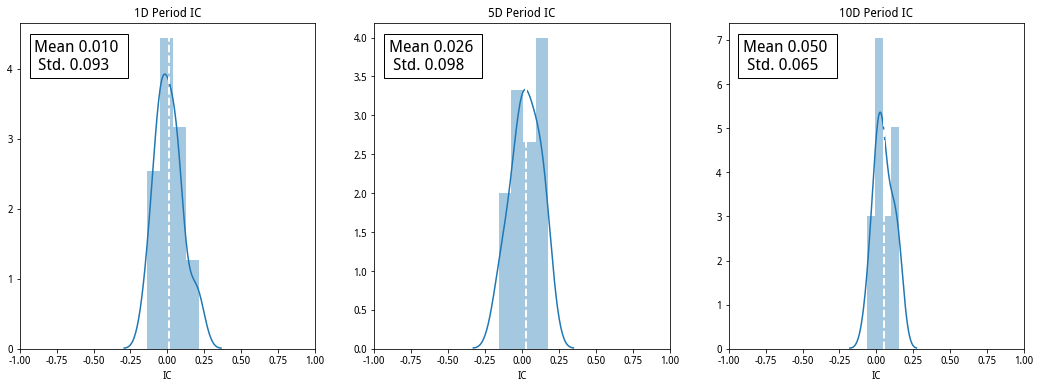

In [23]:
#因子分布图
plotting.plot_ic_hist(ic)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcea054f780>,
      dtype=object)

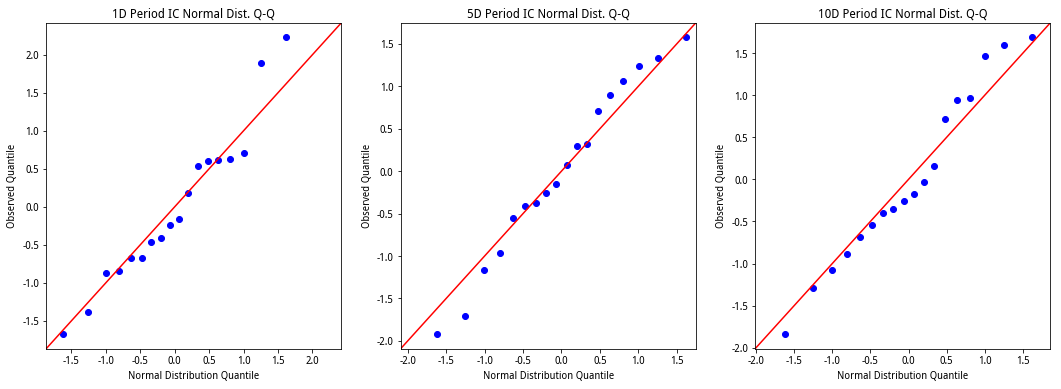

In [24]:
plotting.plot_ic_qq(ic)

In [25]:
#ic>0.02的比例
a = ic.iloc[:,0]
len(a[a>0.02])/len(a)

0.4444444444444444

In [26]:
#ir，代表了稳定性,平均值除以标准差


# 用alphalens进行因子收益率分析

Returns Analysis


,1D,5D,10D
Ann. alpha,0.363,0.428,0.426
beta,-0.073,-0.060,-0.015
Mean Period Wise Return Top Quantile (bps),22.781,24.537,23.404
Mean Period Wise Return Bottom Quantile (bps),-5.398,-7.356,-7.397
Mean Period Wise Spread (bps),28.178,31.868,30.795


/usr/local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


<Figure size 432x288 with 0 Axes>

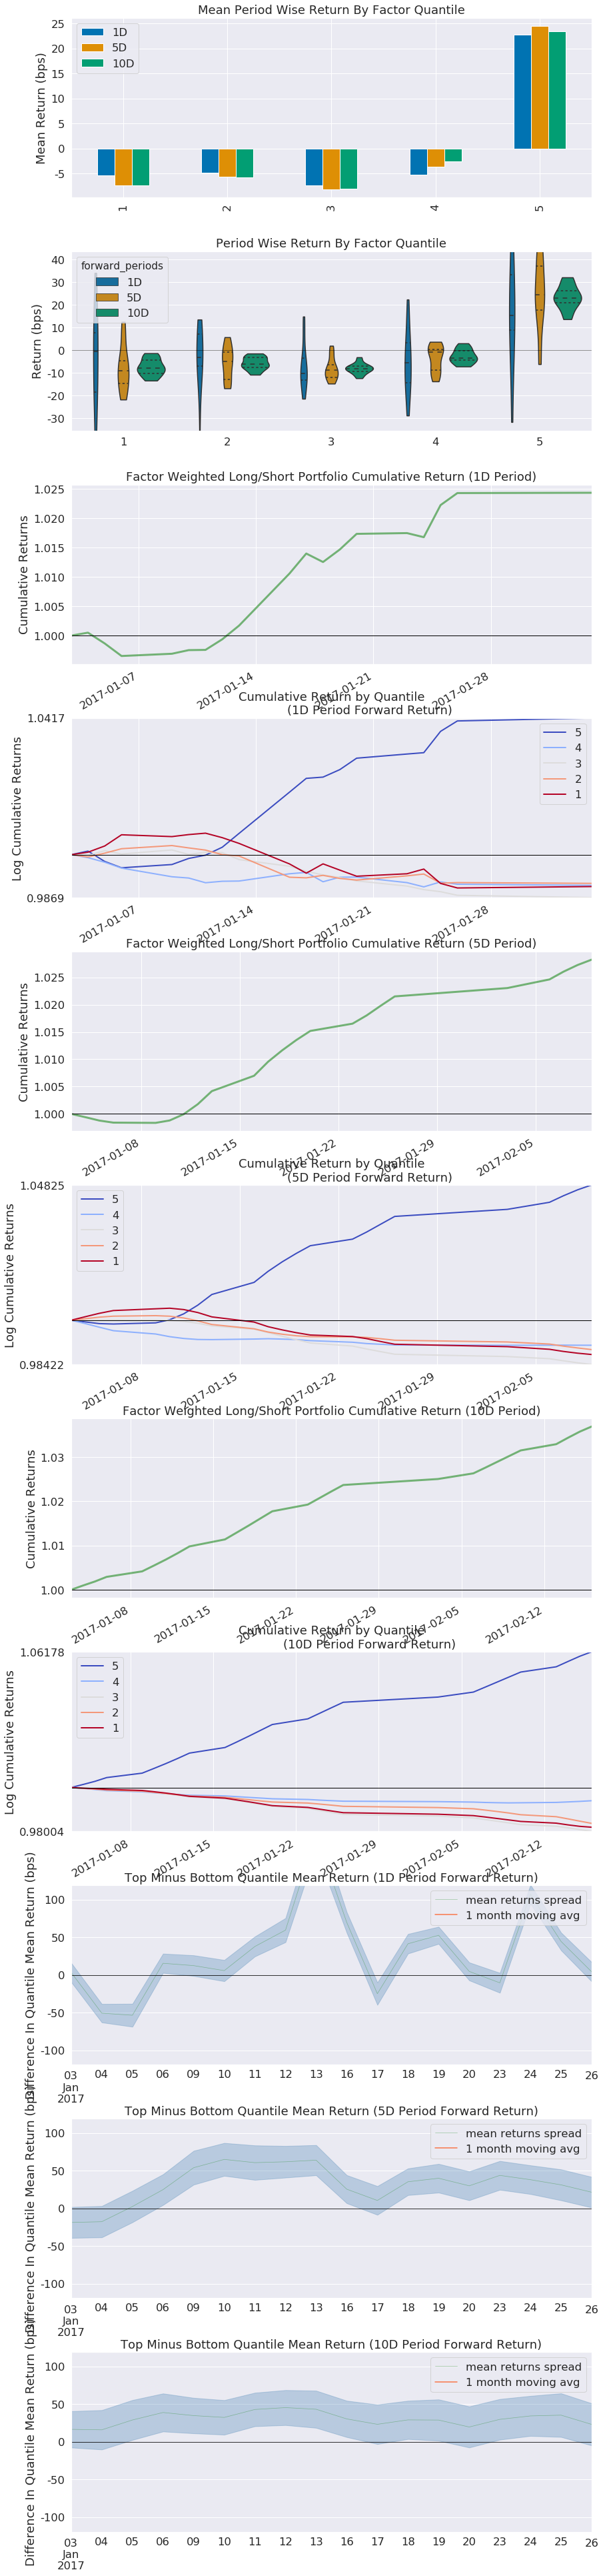

In [27]:
tears.create_returns_tear_sheet(factor_return)

In [28]:
performance.factor_returns(factor_return)

,1D,5D,10D
date,,,
2017-01-03,0.000498,-0.002968,0.009584
2017-01-04,-0.001842,-0.003253,0.008550
2017-01-05,-0.002138,0.000521,0.013580
2017-01-06,0.000386,0.004816,0.018051
2017-01-09,0.000620,0.012023,0.016306
2017-01-10,0.000041,0.014704,0.014713
2017-01-11,0.001814,0.014011,0.020428
2017-01-12,0.002334,0.014424,0.021250
2017-01-13,0.008855,0.015173,0.019410


# 按上面步骤算出多个类别因子的ic因子，并分析因子的相关性

In [ ]:
#st.spearmanr(ic1.iloc[:,0],ic2.iloc[:,0])
#用斯皮尔曼得出各因子的相关性 

In [29]:
earn_return = pd.DataFrame()

# 进行因子合成

In [30]:
for i in range(len(date)):
    #取出两个因子数据
    
    q = query(fundamentals.income_statement.basic_earnings_per_share,
             fundamentals.financial_indicator.return_on_equity)
    
    fund = get_fundamentals(q,entry_date=date[i]).iloc[:,0,:]
    
    earn_return = pd.concat([earn_return,fund])
    

/usr/local/lib/python3.6/site-packages/rqdatac/services/financial.py:339: UserWarning: Panel is  removed after pandas version 0.25.0.the  default value of 'expect_df' will change to True in the future.
  warnings.warn("Panel is  removed after pandas version 0.25.0."


In [31]:
from sklearn.decomposition import PCA

In [33]:
earn_return['basic_earnings_per_share'] = earn_return['basic_earnings_per_share'].fillna(earn_return['basic_earnings_per_share'].mean())
earn_return['return_on_equity'] = earn_return['return_on_equity'].fillna(earn_return['return_on_equity'].mean())

In [35]:
pca = PCA(n_components=1)

In [37]:
pca.fit_transform(earn_return[['basic_earnings_per_share','return_on_equity']])

array([[  3.81600651],
       [  7.31707864],
       [  2.19884016],
       ...,
       [ -6.76961587],
       [-15.16994133],
       [ -4.63366107]])